Для задачи возьмём датасет Depression: Reddit Dataset (Cleaned)

> About Dataset

> The raw data is collected through web scrapping Subreddits and is cleaned using multiple NLP techniques. The data is only in English language. It mainly targets mental health classification.


**Тип задачи**: бинарная классификация.

**Цель**: узнать какой из популярных алгоритмов машинного обучения лучше справится с задачей классификации. Вывести матрицы ошибок, построить графики.

Т.к. используемый датасет уже является предварительно подготовленым (слова приведены к нижнему регистру, убраны знаки препинания, выполнена лемматизация), выделим следующие этапы выполнения работы:

1. Импорт библиотек для работы с датасетом
2. Работа с датасетом

    2.1 Удаление дубликатов

    2.2. Проверка сбалансированности
    
    2.3. Перевод текста в массив (CountVectorizer)

    2.4. Разбивка на обучающую и тестовые выборки

3. Работа с моделями

    3.1. Создание словаря с моделями
    
    3.2. Подбор моделей по обучающей выборке

    3.3. Расчёт точности моделей по тестовой выборке

4. Построение графиков

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/depression_dataset_reddit_cleaned.csv')
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [ ]:
print(df.value_counts())

clean_text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       is_depression
i want to be dead ive been suicidal for year im such a fucking retard filled with regret and anger im done with life i want all of this to stop why i cant do one thing right                                            

Обнаружились дубликаты. Выполним очистку

In [ ]:
df.drop_duplicates(subset='clean_text', inplace=True)

In [ ]:
print(df['is_depression'].value_counts())

is_depression
0    3889
1    3761
Name: count, dtype: int64


Кол-во меток 'is_depression' сбалансировано, значений 0 и 1 приблизительно поровну

Создадим объект класса CountVectorizer, оставим 500 наиболее часто встречающихся слов

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english', max_features=500)

# переводим столбец 'clean_text' в массив numpy
matrix = count.fit_transform(df['clean_text']).toarray()
print(type(matrix))

<class 'numpy.ndarray'>


Осуществим разбивку на обучающую и тестовую выборку

In [ ]:
from sklearn.model_selection import train_test_split

x = matrix
y = df['is_depression'].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20, stratify=y)

Работа с моделями: создаём словарь: ключи - название, значения - класс для этой модели из библиотеки scikit-learn. Выполним перебор по словарю, осуществим подбор модели методом fit, расчёт точности на тестовой выборке методом score, расчёт матрицы ошибок на тестовой выборке. Сохраняем результаты для построения графиков

In [ ]:
from datetime import datetime
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

models = {
    'Logistic Regression': LogisticRegression(),
    'Softmax Regression': LogisticRegression(multi_class='multinomial'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Gaussian Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    # 'Linear Discriminant Analysis': LinearDiscriminantAnalysis()
}

models_score = {}
cms = {}
time_score = {}

for name, model in models.items():
    start_time = datetime.now()
    model.fit(x_train, y_train)
    time_score[name] = datetime.now() - start_time  # затраченное время
    accuracy = model.score(x_test, y_test)
    print(f'{name} Accuracy: {accuracy}')
    models_score[name] = accuracy * 100
    cm = confusion_matrix(y_test, model.predict(x_test))
    print(cm)
    cms[name] = cm

Logistic Regression Accuracy: 0.9581699346405229
[[769   9]
 [ 55 697]]
Softmax Regression Accuracy: 0.9549019607843138
[[765  13]
 [ 56 696]]
Decision Tree Accuracy: 0.9248366013071896
[[735  43]
 [ 72 680]]
Random Forest Accuracy: 0.9457516339869281
[[759  19]
 [ 64 688]]
Support Vector Machine Accuracy: 0.9529411764705882
[[775   3]
 [ 69 683]]
Gaussian Naive Bayes Accuracy: 0.934640522875817
[[744  34]
 [ 66 686]]
K-Nearest Neighbors Accuracy: 0.7973856209150327
[[776   2]
 [308 444]]


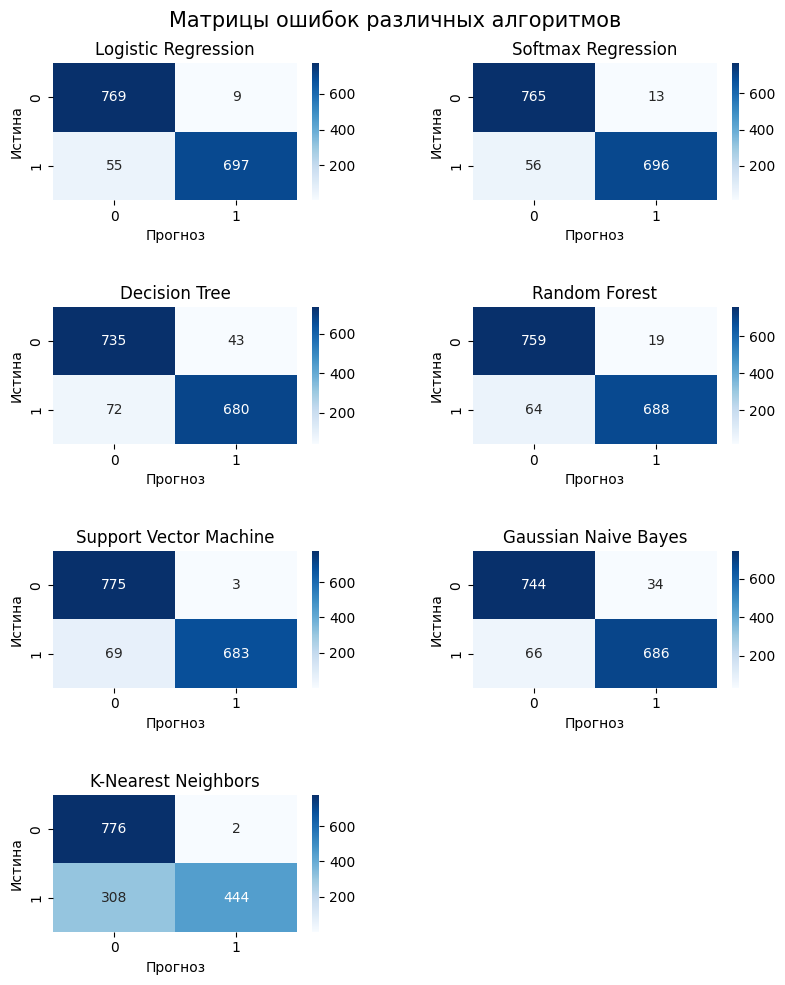

In [ ]:
# количество подграфиков
num_plots = len(cms)
cols = 2  # количество столбцов в сетке подграфиков
rows = (num_plots + cols - 1) // cols  # количество строк в сетке подграфиков

# создание подграфиков
fig, axes = plt.subplots(rows, cols, figsize=(8, 10))
plt.suptitle('Матрицы ошибок различных алгоритмов', fontsize=15)

# преобразование axes в одномерный массив для удобства итерации
axes = axes.flatten()

# построение каждого подграфика
for i, (title, cm) in enumerate(cms.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel('Прогноз')
    axes[i].set_ylabel('Истина')

# удаление пустых подграфиков, если их больше, чем нужно
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(h_pad=3, w_pad=5)
plt.show()

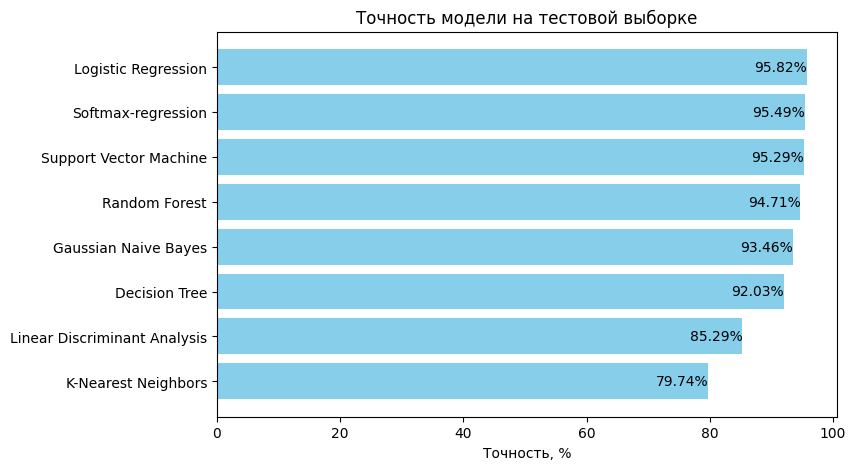

In [ ]:
sorted_models_score = dict(sorted(models_score.items(), key=lambda item: item[1], reverse=True))

models = list(sorted_models_score.keys())
scores = list(sorted_models_score.values())

# построение горизонтального графика
plt.figure(figsize=(8, 5))
bars = plt.barh(models, scores, color='skyblue')
plt.xlabel('Точность, %')
plt.title('Точность модели на тестовой выборке')
plt.gca().invert_yaxis()  # инвертируем ось Y для отображения от большего к меньшему

# добавление подписей к каждому бару
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%',
             va='center', ha='right', color='black')

plt.show()

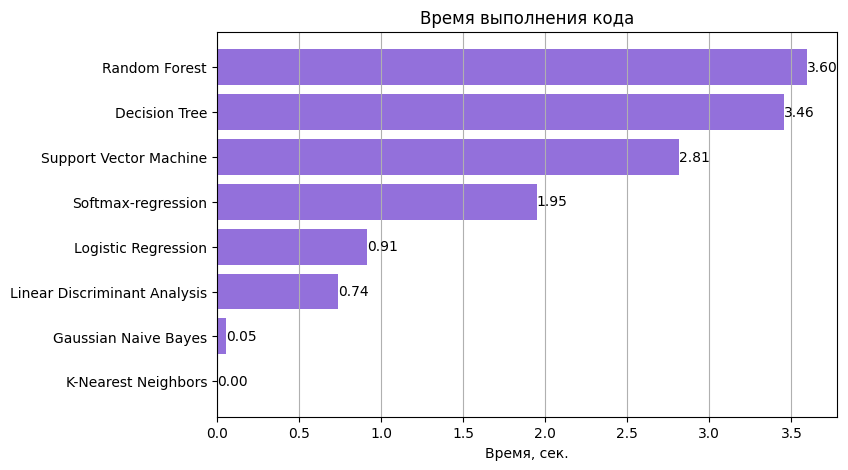

In [ ]:
# преобразование данных в формат, удобный для построения графика
model_names = list(time_score.keys())
times = [time.total_seconds() for time in time_score.values()]

# сортировка данных по времени выполнения
sorted_indices = sorted(range(len(times)), key=lambda k: times[k])
sorted_model_names = [model_names[i] for i in sorted_indices]
sorted_times = [times[i] for i in sorted_indices]

# построение горизонтального графика
plt.figure(figsize=(8, 5))
bars = plt.barh(sorted_model_names, sorted_times, color='mediumpurple')
plt.xlabel('Время, сек.')
plt.title('Время выполнения кода')
plt.grid(axis='x')

# добавление подписей к каждому бару
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}',
             va='center', ha='left', color='black')

plt.show()